# Project 2 - Medical Imaging 

## Imports

In [137]:
import os 
import re 

import numpy as np 
import pandas as pd 
from PIL import Image 
from matplotlib import pyplot as plt 
import seaborn as sns 

from skimage import morphology 
from skimage.transform import rotate 

from sklearn.preprocessing import StandardScaler 

from sklearn.feature_selection import mutual_info_classif, SelectKBest

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

from time import time 

## Global Variables

In [94]:
# Initial parameters for running the notebook 
PREPROCESS = False
COMPUTE_FEATURES = False 

In [95]:
# Paths to directories used 

ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data"
# IM_DIR = DATA_DIR + "/ISIC-2017_Training_Data"
# MASK_DIR = DATA_DIR + "/ISIC-2017_Training_Part1_GroundTruth"
IM_DIR = DATA_DIR + "/filtered_images"
MASK_DIR = DATA_DIR + "/filtered_masks"
DIAGNOSIS_PATH = DATA_DIR + "/ISIC-2017_Training_Part3_GroundTruth.csv"


In [96]:
# Load all filenames into a dictionary
FILENAMES = {}
FILENAMES['images'] = sorted([IM_DIR + "/" + i for i in list(os.walk(IM_DIR))[0][2]])
FILENAMES['masks'] = sorted([f"{MASK_DIR}/{i}" for i in list(os.walk(MASK_DIR))[0][2]])
FILENAMES['image_num'] = len(FILENAMES['images'])

## Helper functions 

In [97]:
def make_sides_even(image): 
    '''
    Function to make the numbers of columns and rows in 
    an image even. 
    Input: An image 
    Output: An image
    '''
    # Convert image to numpy array
    image = np.array(image)
    
    # Check if the number of rows is even 
    if image.shape[0] % 2 != 0: 
        # Delete the first row
        image = np.delete(image,0,axis = 0)
    
    # Check if the number of columns is even 
    if image.shape[1] % 2 != 0: 
        # Delete the first column
        image = np.delete(image,0,axis = 1)
    
    # Convert numpy array back to image 
    image = Image.fromarray(image)
    # Return the updated image 
    return image

In [98]:
def filter_and_crop_image(image_path,mask_path): 
    '''
    Function to filter filter an image based on a given mask 
    and crop both image and mask to the relevant area. 
    '''
    # Instantiate both image and mask 
    image = Image.open(image_path) 
    mask = Image.open(mask_path)
    
    # Crop both image and mask to the bounding box
    # of the mask. 
    image_crop = image.crop(mask.getbbox())
    mask_crop = mask.crop(mask.getbbox())
    
    # Make the length and height of the the image and 
    # mask even 
    image_crop = make_sides_even(image_crop)
    mask_crop = make_sides_even(mask_crop)

    # Instantiate a blank image for a composite image
    tmp_image = Image.new("RGB",image_crop.size, 0)

    # Create a composite image based on the blank image, 
    # the cropped image and the mask 
    filtered_image = Image.composite(image_crop,tmp_image,mask_crop)
    
    # Return the filtered image, the cropped mask and the cropped image 
    return filtered_image, mask_crop, image_crop

## Preprocessing

In [99]:
# Check if the PREPROCESS variable is True 
if PREPROCESS: 
    # Try to create directories for the filtered images, cropped masks 
    # and cropped images 
    try: 
        os.makedirs(DATA_DIR + "/filtered_images")
        os.makedirs(DATA_DIR + "/filtered_masks")
        os.makedirs(DATA_DIR + "/cropped_images")

    except FileExistsError:
        print("Directories exist")
    except IsADirectoryError: 
        print("Directories exist")

    # Instantiate variables containing the paths to the filtered images, 
    # cropped masks and cropped images 
    IMAGE_FILTER_DIR = DATA_DIR + "/filtered_images"
    MASK_FILTER_DIR = DATA_DIR + "/filtered_masks"
    IMAGE_CROP_DIR = DATA_DIR + "/cropped_images"

    # Loop over all images and masks based on the number of images
    for i in range(FILENAMES['image_num']):
        # Instantiate variables with the paths to the currently processing image
        # and mask 
        mask_path = FILENAMES['masks'][i]
        image_path = FILENAMES['images'][i]

        # Filter and crop the image and mask 
        image, mask, crop = filter_and_crop_image(image_path,mask_path)

        # Instantiate variables containing the image and mask name 
        image_name = image_path.split("/")[-1].split(".")[-2]
        mask_name = mask_path.split("/")[-1].split(".")[-2]

        # Save the generated images and mask to files 
        image.save(IMAGE_FILTER_DIR + "/" + image_name + ".jpg")
        mask.save(MASK_FILTER_DIR + "/" + mask_name + ".png")
        crop.save(IMAGE_CROP_DIR + "/" + image_name + ".jpg")

        # Clear the temporary variables 
        del mask_path, image_path, image, mask, crop, image_name, mask_name
    
    # Load all the new filenames into the FILENAMES dictionary
    FILENAMES['filtered_images'] = sorted([f"{IMAGE_FILTER_DIR}/{i}" for i in list(os.walk(IMAGE_FILTER_DIR))[0][2]])
    FILENAMES['cropped_images'] = sorted([f"{IMAGE_CROP_DIR}/{i}" for i in list(os.walk(IMAGE_CROP_DIR))[0][2]])
    FILENAMES['cropped_masks'] = sorted([f"{MASK_FILTER_DIR}/{i}" for i in list(os.walk(MASK_FILTER_DIR))[0][2]])
else: 
    # Instantiate variables containing the paths to the filtered images, 
    # cropped masks and cropped images 
    IMAGE_FILTER_DIR = DATA_DIR + "/filtered_images"
    MASK_FILTER_DIR = DATA_DIR + "/filtered_masks"
    IMAGE_CROP_DIR = DATA_DIR + "/cropped_images"

    # Load all the new filenames into the FILENAMES dictionary
    FILENAMES['filtered_images'] = sorted([f"{IMAGE_FILTER_DIR}/{i}" for i in list(os.walk(IMAGE_FILTER_DIR))[0][2]])
    FILENAMES['cropped_images'] = sorted([f"{IMAGE_CROP_DIR}/{i}" for i in list(os.walk(IMAGE_CROP_DIR))[0][2]])
    FILENAMES['cropped_masks'] = sorted([f"{MASK_FILTER_DIR}/{i}" for i in list(os.walk(MASK_FILTER_DIR))[0][2]])


## Feature Extraction Functions

In [100]:
## Find the area and perimeter of the mask 
def get_area_perimeter(mask, erosion=2): 
    '''
    Function which takes in a mask for a
    given image and returns the area and 
    perimeter of the mask. 
    '''

    # Convert the mask to a Numpy array containing 1's and 0's
    mask = np.where(np.array(mask) ==255,1,0)

    # Calculate the area of the mask as the sum of the Numpy array
    area = np.sum(mask)
    
    # Erode the edge of the mask in order to calculate the perimeter 
    mask_erosion = morphology.binary_erosion(mask,morphology.disk(erosion))
        
    # Calculate the perimeter 
    perimeter = np.sum(mask - mask_erosion)
    # Return the area and the perimeter 
    return area, perimeter

In [101]:
def get_compactness(mask): 
    '''
    Function which takes in a mask for a given 
    image, calls the get_area_perimeter function
    to get the area and perimeter, and returns a 
    compactness score based upon [CITATION NEEDED]. 
    '''
    # Calculate the area and the perimeter 
    area, perimeter = get_area_perimeter(mask) 
    # Calculate the compactness 
    compactness = perimeter ** 2 / (4 * np.pi * area)
    # Return the compactness 
    return compactness 

In [102]:
def get_asymmetry(mask, rotation=45): 
    '''
    Takes in a mask for a given image, rotates it 
    180 times by one degree, compares the left and 
    right half and returns an average asymmetry score.
    '''
    # Instantiate the mask as a Numpy array 
    mask = np.array(mask)
    axes = 0 
    # Get the length and width of the mask 
    height, width = mask.shape 
    
    # Get the area of the lesion 
    lesion_area = len(np.where(mask != 0)[0])

    # Instantiate a list to holds the calculated differences  
    diffs = []

    while axes * rotation < 180:
        temp_mask = rotate(mask, axes * rotation)
        # length_lesion = np.nonzero(np.sum(temp_mask, axis = 0))[0][-1] - np.nonzero(np.sum(temp_mask, axis = 0))[0][0]

        left_mask = temp_mask[:, :int(width/2)] 
        right_mask = temp_mask[:, int(width/2):]
        right_mask = np.fliplr(right_mask)
        rotation_diff = np.where(left_mask != right_mask)
    
        diffs.append(len(rotation_diff[0]))
        
        axes += 1
    
    diff = np.mean(diffs)
    
    return diff / lesion_area 



In [103]:
def get_average_luminance(image): 
    '''
    A function which takes in an image and
    returns the average luminance. 
    Input: A PIL Image 
    Output: Average luminance of the image
    '''
    # Convert the image to grayscale and then to a Numpy array 
    grayscale = np.array(image.convert('L'))

    # Calculate the mean of the luminance
    average_luminance = round(np.mean(grayscale[grayscale > 0]))

    # Return the average luminance 
    return average_luminance

In [104]:
def get_luminance_variability(image,measure="variance"): 

    # Convert the image to grayscale and then to a Numpy array 
    grayscale = np.array(image.convert('L'))

    # Check if measure is 'variance'
    if measure == 'variance': 
        # Using numpy's variance method, return the variance in luminance
        return round(np.var(grayscale[grayscale > 0]))
    # Check if measure is 'standard_deviation'
    elif measure == "standard_deviation": 
        # Using numpy's standard deviation method, return the standard deviation
        return round(np.std(grayscale[grayscale > 0]))
    else: 
        # If measure is neither 'variance' nor 'standard_deviation', raise a 
        # ValueError. 
        raise ValueError("Only 'variance' or 'standard_deviation' accepted.") 

In [105]:
def get_avg_color(image): 
    '''
    A function which takes in an image and returns 
    the average color of the image. 
    '''
    # Split the image into separate color channels 
    r, g, b = image.split()
    # Instantiate a numpy array based on each color channel 
    r = np.array(r)
    g = np.array(g)
    b = np.array(b)
    # Calculate the mean of each color channel 
    average_color = (
        round(np.mean(r[r > 0])), 
        round(np.mean(g[g > 0])), 
        round(np.mean(b[b > 0]))
    )
    # Return a tuple of the average color 
    return average_color

In [106]:
def get_color_variance(image,measure="variance"): 
    '''
    A function which takes in an image and 
    returns the variance of the color. 
    '''
    # Split the image into separate color channels 
    r, g, b = image.split()
    # Instantiate a numpy array based on each color channel 
    r = np.array(r)
    g = np.array(g)
    b = np.array(b)
    # Check if measure is 'variance'
    if measure == "variance": 
        # Using numpy's variance method, calculate the variance of each color
        rgb = (
            np.var(r[r>0]),
            np.var(g[g>0]),
            np.var(b[b>0])
        )
    # Check if measure is 'standard_deviation'
    elif measure == "standard_deviation": 
        # Using numpy's standard deviation method, calculate the standard deviation
        # of each color 
        rgb = (
            np.std(r[r>0]),
            np.std(g[g>0]),
            np.std(b[b>0])
        )
    else: 
        # If measure is neither 'variance' nor 'standard_deviation', raise 
        # a ValueError 
        raise ValueError("Only 'variance' or 'standard_deviation' accepted.") 
    # Return the mean of the variances or standard deviation of the 3 colors
    return np.mean(rgb)

## Feature Extraction 

In [107]:
# Check if the COMPUTE_FEATURES variable is True 
if COMPUTE_FEATURES: 
    #Instantiate a dictionary to store the features and image_id's 
    feature_dictionary = {
        "image_id": [],
        "area": [], 
        "perimeter": [],
        "compactness": [], 
        "asymmetry": [], 
        "luminance_average": [],
        "luminance_variance": [],
        "red_average": [],
        "green_average": [],
        "blue_average": [],
        "color_variance": [],
    }

    # Loop over all filtered images and cropped masks 
    for i in range(FILENAMES['image_num']): 
        # Instantiate variables containing the paths to the image and mask
        filtered_image_path = FILENAMES['filtered_images'][i]
        cropped_mask_path = FILENAMES['cropped_masks'][i]

        # Get the image name from the image path 
        image_name = filtered_image_path.split("/")[-1].split(".")[-2]

        print(f"Currently working on {i} - Image id: {image_name}")

        # Open both the image and mask as PIL Images 
        filtered_image = Image.open(filtered_image_path)
        cropped_mask = Image.open(cropped_mask_path)

        # Calculate all features and append them to the relevant list in 
        # the feature_dictionary 
        feature_dictionary['image_id'].append(image_name)
        area, perimeter = get_area_perimeter(cropped_mask)
        feature_dictionary['area'].append(area)
        feature_dictionary['perimeter'].append(perimeter)
        feature_dictionary['compactness'].append(get_compactness(cropped_mask))
        feature_dictionary['asymmetry'].append(get_asymmetry(cropped_mask))
        feature_dictionary['luminance_average'].append(get_average_luminance(filtered_image))
        feature_dictionary['luminance_variance'].append(get_luminance_variability(filtered_image))
        red, green, blue = get_avg_color(filtered_image)
        feature_dictionary['red_average'].append(red)
        feature_dictionary['green_average'].append(green)
        feature_dictionary['blue_average'].append(blue)
        feature_dictionary['color_variance'].append(get_color_variance(filtered_image))
    # Instantiate a pandas DataFrame based on the feature_dictionary
    features = pd.DataFrame(feature_dictionary)
    # Write the features DataFrame to .csv 
    features.to_csv(ROOT_DIR + "/features/feature_set.csv",sep=";",index=False)
else: 
    # Read the previously calculated feature set into a pandas DataFrame 
    features = pd.read_csv(ROOT_DIR + "/features/feature_set.csv", sep=";", index_col=False)

    

## Feature Selection 

In [139]:
## Create list of features 
feature_list = list(features.columns)[1:]


## Load the Melanoma data 
data = pd.read_csv("../data/ISIC-2017_Training_Part3_GroundTruth.csv")

## Merge the Melanoma data with the feature data 
image_data = pd.merge(features, data, on = "image_id")




In [109]:
# Create feature Dataframe and melanoma DataFrame
X = image_data[feature_list]
y = image_data['melanoma']

In [110]:
## Split into development data and test data 
X_dev, X_test, y_dev, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)

In [111]:
## Normalize using Scikit-Learn's StandardScaler 
scaler = StandardScaler().fit(X_dev)
X_dev = pd.DataFrame(scaler.transform(X_dev.values), columns=X_dev.columns)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns)


In [112]:
## Create Noise columns 
noise_cols = 4 
features_noise = feature_list + ['Noise' for _ in range(noise_cols)]
noise = np.random.RandomState(1).uniform(0,0.1, size = (noise_cols, X_dev.shape[0])).transpose()


# Merge noise columns with the feature columns 
X_select = np.hstack((X_dev,noise))
y_select = y_dev 


for k in range(1, 5+1): 
    kbest = SelectKBest(mutual_info_classif, k=k)
    kbest.fit(X_select, y_select)
    scores = kbest.scores_ 

    print(f"k = {k}\n")
    score_dict = {scores[i]: i for i in range(len(scores))}
    #print(sorted(score_dict))
    for val in sorted(score_dict, reverse=True)[:k]:
        # print(score_dict[val])
        print(features_noise[score_dict[val]])
    print()
    


k = 1

perimeter

k = 2

perimeter
asymmetry

k = 3

perimeter
asymmetry
area

k = 4

perimeter
asymmetry
area
Noise

k = 5

perimeter
asymmetry
area
Noise
blue_average



## Exploring the addition of Age and Sex to the test set 


In [113]:
## Load the Melanoma data 
data = pd.read_csv("../data/ISIC-2017_Training_Part3_GroundTruth.csv")

## Load the Age and Sex data 

age_sex = pd.read_csv("../data/ISIC-2017_Training_Data_metadata.csv")


## Merge the Age and Sex data with the merged 
merged_df = pd.merge(image_data, age_sex, on = 'image_id')


In [114]:
# Convert "unknown" to none  
merged_df['age_approximate'] = [i if i != "unknown" else None for i in merged_df['age_approximate']]

In [115]:
# Convert 'male' to -1, 'female' to 1 and 'unknown' to none 
merged_df['sex'] = [-1 if i == "male" else 1 if i == "female" else None for i in merged_df['sex']]

In [116]:
# Create feature list 
column_list = list(merged_df.columns)
feature_list = []
for i in column_list:
    if i != 'melanoma' and i != 'image_id' and i !=  'seborrheic_keratosis': 
        feature_list.append(i)

In [117]:
# Remove rows with null values 
merged_without_none = merged_df.dropna()

In [118]:
# Create feature Dataframe and melanoma DataFrame
X_ageSex = merged_without_none[feature_list]
y_ageSex = merged_without_none['melanoma']

In [119]:
## Split into development data and test data 
X_dev_ageSex, X_test_ageSex, y_dev_ageSex, y_test_ageSex = train_test_split(X_ageSex, y_ageSex, stratify=y_ageSex, test_size=0.3, random_state=1)

In [120]:
## Normalize using Scikit-Learn's StandardScaler 
scaler = StandardScaler().fit(X_dev_ageSex)
X_dev_ageSex = pd.DataFrame(scaler.transform(X_dev_ageSex.values), columns=X_dev_ageSex.columns)
X_test_ageSex = pd.DataFrame(scaler.transform(X_test_ageSex.values), columns=X_test_ageSex.columns)

In [121]:
## Create Noise columns 
noise_cols = 4 
features_noise = feature_list + ['Noise' for _ in range(noise_cols)]
noise = np.random.RandomState(1).uniform(0,0.1, size = (noise_cols, X_dev_ageSex.shape[0])).transpose()


# Merge noise columns with the feature columns 
X_select = np.hstack((X_dev_ageSex,noise))
y_select = y_dev_ageSex 


for k in range(1, 5+1): 
    kbest = SelectKBest(mutual_info_classif, k=k)
    kbest.fit(X_select, y_select)
    scores = kbest.scores_ 

    print(f"k = {k}\n")
    score_dict = {scores[i]: i for i in range(len(scores))}
    # print(sorted(score_dict))
    for val in sorted(score_dict, reverse=True)[:k]:
        # print(score_dict[val])
        print(features_noise[score_dict[val]])

k = 1

age_approximate
k = 2

age_approximate
sex
k = 3

age_approximate
perimeter
area
k = 4

age_approximate
sex
perimeter
area
k = 5

age_approximate
perimeter
area
Noise
Noise


## Generate Tables and Figures

# Classifiers

In [122]:

# According to the features selection best features are perimeter, asymmetry and red_average

feature_list = ["perimeter", "asymmetry", "red_average"]


# Creates a random variable between 1 and 100 to facilitate splitting the data into multiple sets
np.random.seed(0)
separator = np.random.randint(1, 101, size = (image_data.shape[0], 1))

# Creates 20 random noise variable to avoid overfitting
noise = pd.DataFrame(data = np.random.RandomState(23).uniform(0, 0.1, size = (image_data.shape[0], 20)), columns = [i for i in range(20)])

X_main = image_data[feature_list]
X_noisy = pd.merge(X_main, noise, left_index = True, right_index = True)

X_noisy_scaled = StandardScaler().fit_transform(X_noisy.values)
X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, index=X_noisy.index, columns=X_noisy.columns)
X_noisy_scaled_df["separator"] = separator

y = image_data["melanoma"]

#Separating the dataset into 5 different validation sets and 1 test set
X_val1, y_val1 = X_noisy_scaled_df[X_noisy_scaled_df["separator"] < 16], y[X_noisy_scaled_df["separator"] < 16]
X_val2, y_val2 = X_noisy_scaled_df[X_noisy_scaled_df["separator"] > 15][X_noisy_scaled_df["separator"] < 31], y[X_noisy_scaled_df["separator"] > 15][X_noisy_scaled_df["separator"] < 31]
X_val3, y_val3 = X_noisy_scaled_df[X_noisy_scaled_df["separator"] > 30][X_noisy_scaled_df["separator"] < 46], y[X_noisy_scaled_df["separator"] > 30][X_noisy_scaled_df["separator"] < 46]
X_val4, y_val4 = X_noisy_scaled_df[X_noisy_scaled_df["separator"] > 45][X_noisy_scaled_df["separator"] < 61], y[X_noisy_scaled_df["separator"] > 45][X_noisy_scaled_df["separator"] < 61]
X_val5, y_val5 = X_noisy_scaled_df[X_noisy_scaled_df["separator"] > 60][X_noisy_scaled_df["separator"] < 76], y[X_noisy_scaled_df["separator"] > 60][X_noisy_scaled_df["separator"] < 76]
X_test, y_test= X_noisy_scaled_df[X_noisy_scaled_df["separator"] > 75], y[X_noisy_scaled_df["separator"] > 75]

validation_sets = [(X_val1, y_val1), (X_val2, y_val2), (X_val3, y_val3), (X_val4, y_val4), (X_val5, y_val5)]

#Creating the training sets from the validation sets
X_train1 = pd.concat([X_val2, X_val3, X_val4, X_val5])
X_train2 = pd.concat([X_val1, X_val3, X_val4, X_val5])
X_train3 = pd.concat([X_val1, X_val2, X_val4, X_val5])
X_train4 = pd.concat([X_val1, X_val2, X_val3, X_val5])
X_train5 = pd.concat([X_val1, X_val2, X_val3, X_val4])

y_train1 = pd.concat([y_val2, y_val3, y_val4, y_val5])
y_train2 = pd.concat([y_val1, y_val3, y_val4, y_val5])
y_train3 = pd.concat([y_val1, y_val2, y_val4, y_val5])
y_train4 = pd.concat([y_val1, y_val2, y_val3, y_val5])
y_train5 = pd.concat([y_val1, y_val2, y_val3, y_val4])

training_sets = [(X_train1, y_train1), (X_train2, y_train2), (X_train3, y_train3), (X_train4, y_train4), (X_train5, y_train5)]

<ipython-input-122-6cb08df0833b>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val2, y_val2 = X_noisy_scaled_df[X_noisy_scaled_df["separator"] > 15][X_noisy_scaled_df["separator"] < 31], y[X_noisy_scaled_df["separator"] > 15][X_noisy_scaled_df["separator"] < 31]
<ipython-input-122-6cb08df0833b>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val3, y_val3 = X_noisy_scaled_df[X_noisy_scaled_df["separator"] > 30][X_noisy_scaled_df["separator"] < 46], y[X_noisy_scaled_df["separator"] > 30][X_noisy_scaled_df["separator"] < 46]
<ipython-input-122-6cb08df0833b>:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val4, y_val4 = X_noisy_scaled_df[X_noisy_scaled_df["separator"] > 45][X_noisy_scaled_df["separator"] < 61], y[X_noisy_scaled_df["separator"] > 45][X_noisy_scaled_df["separator"] < 61]
<ipython-input-122-6cb08df0833b>:27: UserWarning: Boolean Series key will be reindexed to match D

In [123]:
# Creating the classifiers

classifiers_name = ["KNN_1", "KNN_3", "KNN_5", "KNN_10", "KNN_50", "Tree", "Gaussian"]
classifiers = []
classifiers.append(KNeighborsClassifier(n_neighbors = 1))
classifiers.append(KNeighborsClassifier(n_neighbors = 3))
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(KNeighborsClassifier(n_neighbors = 10))
classifiers.append(KNeighborsClassifier(n_neighbors = 50))
classifiers.append(DecisionTreeClassifier())
classifiers.append(GaussianProcessClassifier())

accuracy_scores = []
auc_scores = []
f1_scores = []


# Calculating the scores for each classifier for each training set
for i in range(len(training_sets)):
    trained_classifiers = [classifier.fit(training_sets[i][0], training_sets[i][1]) for classifier in classifiers]
    predictions = [trained.predict(validation_sets[i][0]) for trained in trained_classifiers]
    accuracy_scores.append([accuracy_score(validation_sets[i][1], prediction) for prediction in predictions])
    auc_scores.append([roc_auc_score(validation_sets[i][1], prediction) for prediction in predictions])
    f1_scores.append([f1_score(validation_sets[i][1], prediction) for prediction in predictions])


    
    
accuracy_scores_avg = []
auc_scores_avg = []
f1_scores_avg = []

# Calculating the average score for each classifier
for i in range(len(classifiers)):
    accuracy_scores_avg.append(np.mean([accuracy_scores[j][i] for j in range(len(training_sets))]))
    auc_scores_avg.append(np.mean([auc_scores[j][i] for j in range(len(training_sets))]))
    f1_scores_avg.append(np.mean([f1_scores[j][i] for j in range(len(training_sets))]))


columns = ["Classifier", "Accuracy score", "Roc Auc score", "F1 score"]
data = np.array([classifiers_name, np.round(accuracy_scores_avg, decimals = 5), 
                 np.round(auc_scores_avg, decimals = 5), np.round(f1_scores_avg, decimals = 5)]).T
Classifier_evaluation = pd.DataFrame(data = data, columns = columns)
Classifier_evaluation.to_csv(ROOT_DIR + "/features/Classifier_Evaluation",sep=";",index=False)



In [124]:
# Testing the best classifier (decision tree) on the test data

y_test_predict = trained_classifiers[5].predict(X_test)

acc_test = accuracy_score(y_test, y_test_predict)
auc_test = roc_auc_score(y_test, y_test_predict)
f1_test = f1_score(y_test, y_test_predict)

print(acc_test)
print(auc_test)
print(f1_test)

0.7222222222222222
0.5408998988877655
0.24870466321243523


## Age and Sex Classifiers

In [125]:
# Age and Sex classifiers, features are age_approximate, sex, perimeter, area


feature_list = ["age_approximate", "sex", "perimeter", "area"]


# Creates a random variable between 1 and 100 to facilitate splitting the data into multiple sets
np.random.seed()
separator_ageSex = np.random.randint(1, 101, size = (merged_without_none.shape[0], 1))

# Creates 20 random noise variable to avoid overfitting
noise_ageSex = pd.DataFrame(data = np.random.RandomState(23).uniform(0, 0.1, size = (merged_without_none.shape[0], 20)), columns = [i for i in range(20)])

merged_without_none = merged_without_none.reset_index(drop=True)

X_ageSex = merged_without_none[feature_list]
X_noisy_ageSex = pd.merge(X_ageSex, noise_ageSex, left_index = True, right_index = True)


X_noisy_scaled_ageSex = StandardScaler().fit_transform(X_noisy_ageSex.values)
X_noisy_scaled_df_ageSex = pd.DataFrame(X_noisy_scaled_ageSex, index=X_noisy_ageSex.index, columns=X_noisy_ageSex.columns)
X_noisy_scaled_df_ageSex["separator"] = separator_ageSex
y_ageSex = merged_without_none["melanoma"]

#Separating the dataset into 5 different validation sets and 1 test set
X_val1_ageSex, y_val1_ageSex = X_noisy_scaled_df_ageSex[X_noisy_scaled_df_ageSex["separator"] < 16], y_ageSex[X_noisy_scaled_df_ageSex["separator"] < 16]
X_val2_ageSex, y_val2_ageSex = X_noisy_scaled_df_ageSex[X_noisy_scaled_df_ageSex["separator"] > 15][X_noisy_scaled_df_ageSex["separator"] < 31], y_ageSex[X_noisy_scaled_df_ageSex["separator"] > 15][X_noisy_scaled_df_ageSex["separator"] < 31]
X_val3_ageSex, y_val3_ageSex = X_noisy_scaled_df_ageSex[X_noisy_scaled_df_ageSex["separator"] > 30][X_noisy_scaled_df_ageSex["separator"] < 46], y_ageSex[X_noisy_scaled_df_ageSex["separator"] > 30][X_noisy_scaled_df_ageSex["separator"] < 46]
X_val4_ageSex, y_val4_ageSex = X_noisy_scaled_df_ageSex[X_noisy_scaled_df_ageSex["separator"] > 45][X_noisy_scaled_df_ageSex["separator"] < 61], y_ageSex[X_noisy_scaled_df_ageSex["separator"] > 45][X_noisy_scaled_df_ageSex["separator"] < 61]
X_val5_ageSex, y_val5_ageSex = X_noisy_scaled_df_ageSex[X_noisy_scaled_df_ageSex["separator"] > 60][X_noisy_scaled_df_ageSex["separator"] < 76], y_ageSex[X_noisy_scaled_df_ageSex["separator"] > 60][X_noisy_scaled_df_ageSex["separator"] < 76]
X_test_ageSex, y_test_ageSex= X_noisy_scaled_df_ageSex[X_noisy_scaled_df_ageSex["separator"] > 75], y_ageSex[X_noisy_scaled_df_ageSex["separator"] > 75]

validation_sets_ageSex = [(X_val1_ageSex, y_val1_ageSex), (X_val2_ageSex, y_val2_ageSex), (X_val3_ageSex, y_val3_ageSex), (X_val4_ageSex, y_val4_ageSex), (X_val5_ageSex, y_val5_ageSex)]

#Creating the training sets from the validation sets
X_train1_ageSex = pd.concat([X_val2_ageSex, X_val3_ageSex, X_val4_ageSex, X_val5_ageSex])
X_train2_ageSex = pd.concat([X_val1_ageSex, X_val3_ageSex, X_val4_ageSex, X_val5_ageSex])
X_train3_ageSex = pd.concat([X_val1_ageSex, X_val2_ageSex, X_val4_ageSex, X_val5_ageSex])
X_train4_ageSex = pd.concat([X_val1_ageSex, X_val2_ageSex, X_val3_ageSex, X_val5_ageSex])
X_train5_ageSex = pd.concat([X_val1_ageSex, X_val2_ageSex, X_val3_ageSex, X_val4_ageSex])

y_train1_ageSex = pd.concat([y_val2_ageSex, y_val3_ageSex, y_val4_ageSex, y_val5_ageSex])
y_train2_ageSex = pd.concat([y_val1_ageSex, y_val3_ageSex, y_val4_ageSex, y_val5_ageSex])
y_train3_ageSex = pd.concat([y_val1_ageSex, y_val2_ageSex, y_val4_ageSex, y_val5_ageSex])
y_train4_ageSex = pd.concat([y_val1_ageSex, y_val2_ageSex, y_val3_ageSex, y_val5_ageSex])
y_train5_ageSex = pd.concat([y_val1_ageSex, y_val2_ageSex, y_val3_ageSex, y_val4_ageSex])

training_sets_ageSex = [(X_train1_ageSex, y_train1_ageSex), (X_train2_ageSex, y_train2_ageSex), (X_train3_ageSex, y_train3_ageSex), (X_train4_ageSex, y_train4_ageSex), (X_train5_ageSex, y_train5_ageSex)]

<ipython-input-125-f4984570cc68>:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val2_ageSex, y_val2_ageSex = X_noisy_scaled_df_ageSex[X_noisy_scaled_df_ageSex["separator"] > 15][X_noisy_scaled_df_ageSex["separator"] < 31], y_ageSex[X_noisy_scaled_df_ageSex["separator"] > 15][X_noisy_scaled_df_ageSex["separator"] < 31]
<ipython-input-125-f4984570cc68>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val3_ageSex, y_val3_ageSex = X_noisy_scaled_df_ageSex[X_noisy_scaled_df_ageSex["separator"] > 30][X_noisy_scaled_df_ageSex["separator"] < 46], y_ageSex[X_noisy_scaled_df_ageSex["separator"] > 30][X_noisy_scaled_df_ageSex["separator"] < 46]
<ipython-input-125-f4984570cc68>:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val4_ageSex, y_val4_ageSex = X_noisy_scaled_df_ageSex[X_noisy_scaled_df_ageSex["separator"] > 45][X_noisy_scaled_df_ageSex["separator"] < 61], y_ageSex[X_noisy_scaled_df

In [126]:
# Creating the classifiers

classifiers_name = ["KNN_1", "KNN_3", "KNN_5", "KNN_10", "KNN_50", "Tree", "Gaussian"]
classifiers_ageSex = []
classifiers_ageSex.append(KNeighborsClassifier(n_neighbors = 1))
classifiers_ageSex.append(KNeighborsClassifier(n_neighbors = 3))
classifiers_ageSex.append(KNeighborsClassifier(n_neighbors = 5))
classifiers_ageSex.append(KNeighborsClassifier(n_neighbors = 10))
classifiers_ageSex.append(KNeighborsClassifier(n_neighbors = 50))
classifiers_ageSex.append(DecisionTreeClassifier())
classifiers_ageSex.append(GaussianProcessClassifier())


accuracy_scores_ageSex = []
auc_scores_ageSex = []
f1_scores_ageSex = []


# Calculating the scores for each classifier for each training set
for i in range(len(training_sets_ageSex)):
    trained_classifiers_ageSex = [classifier.fit(training_sets_ageSex[i][0], training_sets_ageSex[i][1]) for classifier in classifiers_ageSex]
    predictions_ageSex = [trained.predict(validation_sets_ageSex[i][0]) for trained in trained_classifiers_ageSex]
    accuracy_scores_ageSex.append([accuracy_score(validation_sets_ageSex[i][1], prediction) for prediction in predictions_ageSex])
    auc_scores_ageSex.append([roc_auc_score(validation_sets_ageSex[i][1], prediction) for prediction in predictions_ageSex])
    f1_scores_ageSex.append([f1_score(validation_sets_ageSex[i][1], prediction) for prediction in predictions_ageSex])


    
    
accuracy_scores_ageSex_avg = []
auc_scores_ageSex_avg = []
f1_scores_ageSex_avg = []

# Calculating the average score for each classifier
for i in range(len(classifiers_ageSex)):
    accuracy_scores_ageSex_avg.append(np.mean([accuracy_scores_ageSex[j][i] for j in range(len(training_sets_ageSex))]))
    auc_scores_ageSex_avg.append(np.mean([auc_scores_ageSex[j][i] for j in range(len(training_sets_ageSex))]))
    f1_scores_ageSex_avg.append(np.mean([f1_scores_ageSex[j][i] for j in range(len(training_sets_ageSex))]))


columns = ["Classifier", "Accuracy score", "Roc Auc score", "F1 score"]
data = np.array([classifiers_name, np.round(accuracy_scores_ageSex_avg, decimals = 5), 
                 np.round(auc_scores_ageSex_avg, decimals = 5), np.round(f1_scores_ageSex_avg, decimals = 5)]).T
Classifier_evaluation_ageSex = pd.DataFrame(data = data, columns = columns)
Classifier_evaluation_ageSex.to_csv(ROOT_DIR + "/features/Classifier_Evaluation_ageSex",sep=";",index=False)

In [127]:
# Testing the best classifier (decision tree) on the test data

y_test_predict_ageSex = trained_classifiers_ageSex[5].predict(X_test_ageSex)

acc_test_ageSex = accuracy_score(y_test_ageSex, y_test_predict_ageSex)
auc_test_ageSex = roc_auc_score(y_test_ageSex, y_test_predict_ageSex)
f1_test_ageSex = f1_score(y_test_ageSex, y_test_predict_ageSex)

print(acc_test_ageSex)
print(auc_test_ageSex)
print(f1_test_ageSex)

0.7200902934537246
0.5618911594521351
0.2790697674418604


# Making a prediction about cancer given an image and a mask

In [143]:
tree_trained_model = trained_classifiers[5]
tree_acc_score, tree_auc_score, tree_f1_score = accuracy_scores_avg[5], auc_scores_avg[5], f1_scores_avg[5]

def cancer_model(image, mask, model = tree_trained_model, acc_score = tree_acc_score,
                 auc_score = tree_auc_score, f1_score = tree_f1_score):
    """Given the an RGB JPG colour image and a PNG binary mask
    of a skin lesion this function will print the predicted
    diagnosis along with an evaluation of the model.
    Also returns the diagnosis as a float."""
    
    image_crop = image.crop(mask.getbbox())
    mask_crop = mask.crop(mask.getbbox())
    
    # Make the length and height of the the image and 
    # mask even 
    image_crop = make_sides_even(image_crop)
    cropped_mask = make_sides_even(mask_crop)

    # Instantiate a blank image for a composite image
    tmp_image = Image.new("RGB",image_crop.size, 0)

    # Create a composite image based on the blank image, 
    # the cropped image and the mask 
    filtered_image = Image.composite(image_crop,tmp_image,mask_crop)
    
    
    feature_dictionary = {
        "perimeter": [], 
        "asymmetry": [], 
        "red_average": [],
    }
    
    area, perimeter = get_area_perimeter(cropped_mask)
    feature_dictionary['perimeter'].append(perimeter)
    feature_dictionary['asymmetry'].append(get_asymmetry(cropped_mask))
    red, green, blue = get_avg_color(filtered_image)
    feature_dictionary['red_average'].append(red)
    features = pd.DataFrame(feature_dictionary)
    noise = pd.DataFrame(data = np.full((1, 21), 0), columns = [i for i in range(21)])
    features = pd.merge(features, noise, left_index = True, right_index = True)
    prediction = model.predict(features)
    if int(prediction) == 1:
        diagnosis = "Melanoma"
        
    elif int(prediction) == 0:
        diagnosis = "Healthy"
    print("The predicition is ", diagnosis, " with probability", prediction, ".\n"
          "The accuracy score of the model is ", acc_score, ".\n"
          "The ROC AUC score of the model is ", auc_score, ".\n"
          "The f1 score of the model is ", f1_score, ".\n"
         )
    return prediction

In [144]:
# Example for 1 picture


image = Image.open("../data/filtered_images/ISIC_0000000.jpg")
mask = Image.open("../data/filtered_masks/ISIC_0000000_segmentation.png")


cancer_model(image, mask)

The predicition is  Melanoma  with probability [1.] .
The accuracy score of the model is  0.6981627670227317 .
The ROC AUC score of the model is  0.49669982013035946 .
The f1 score of the model is  0.17728369049703213 .



array([1.])

# Plots

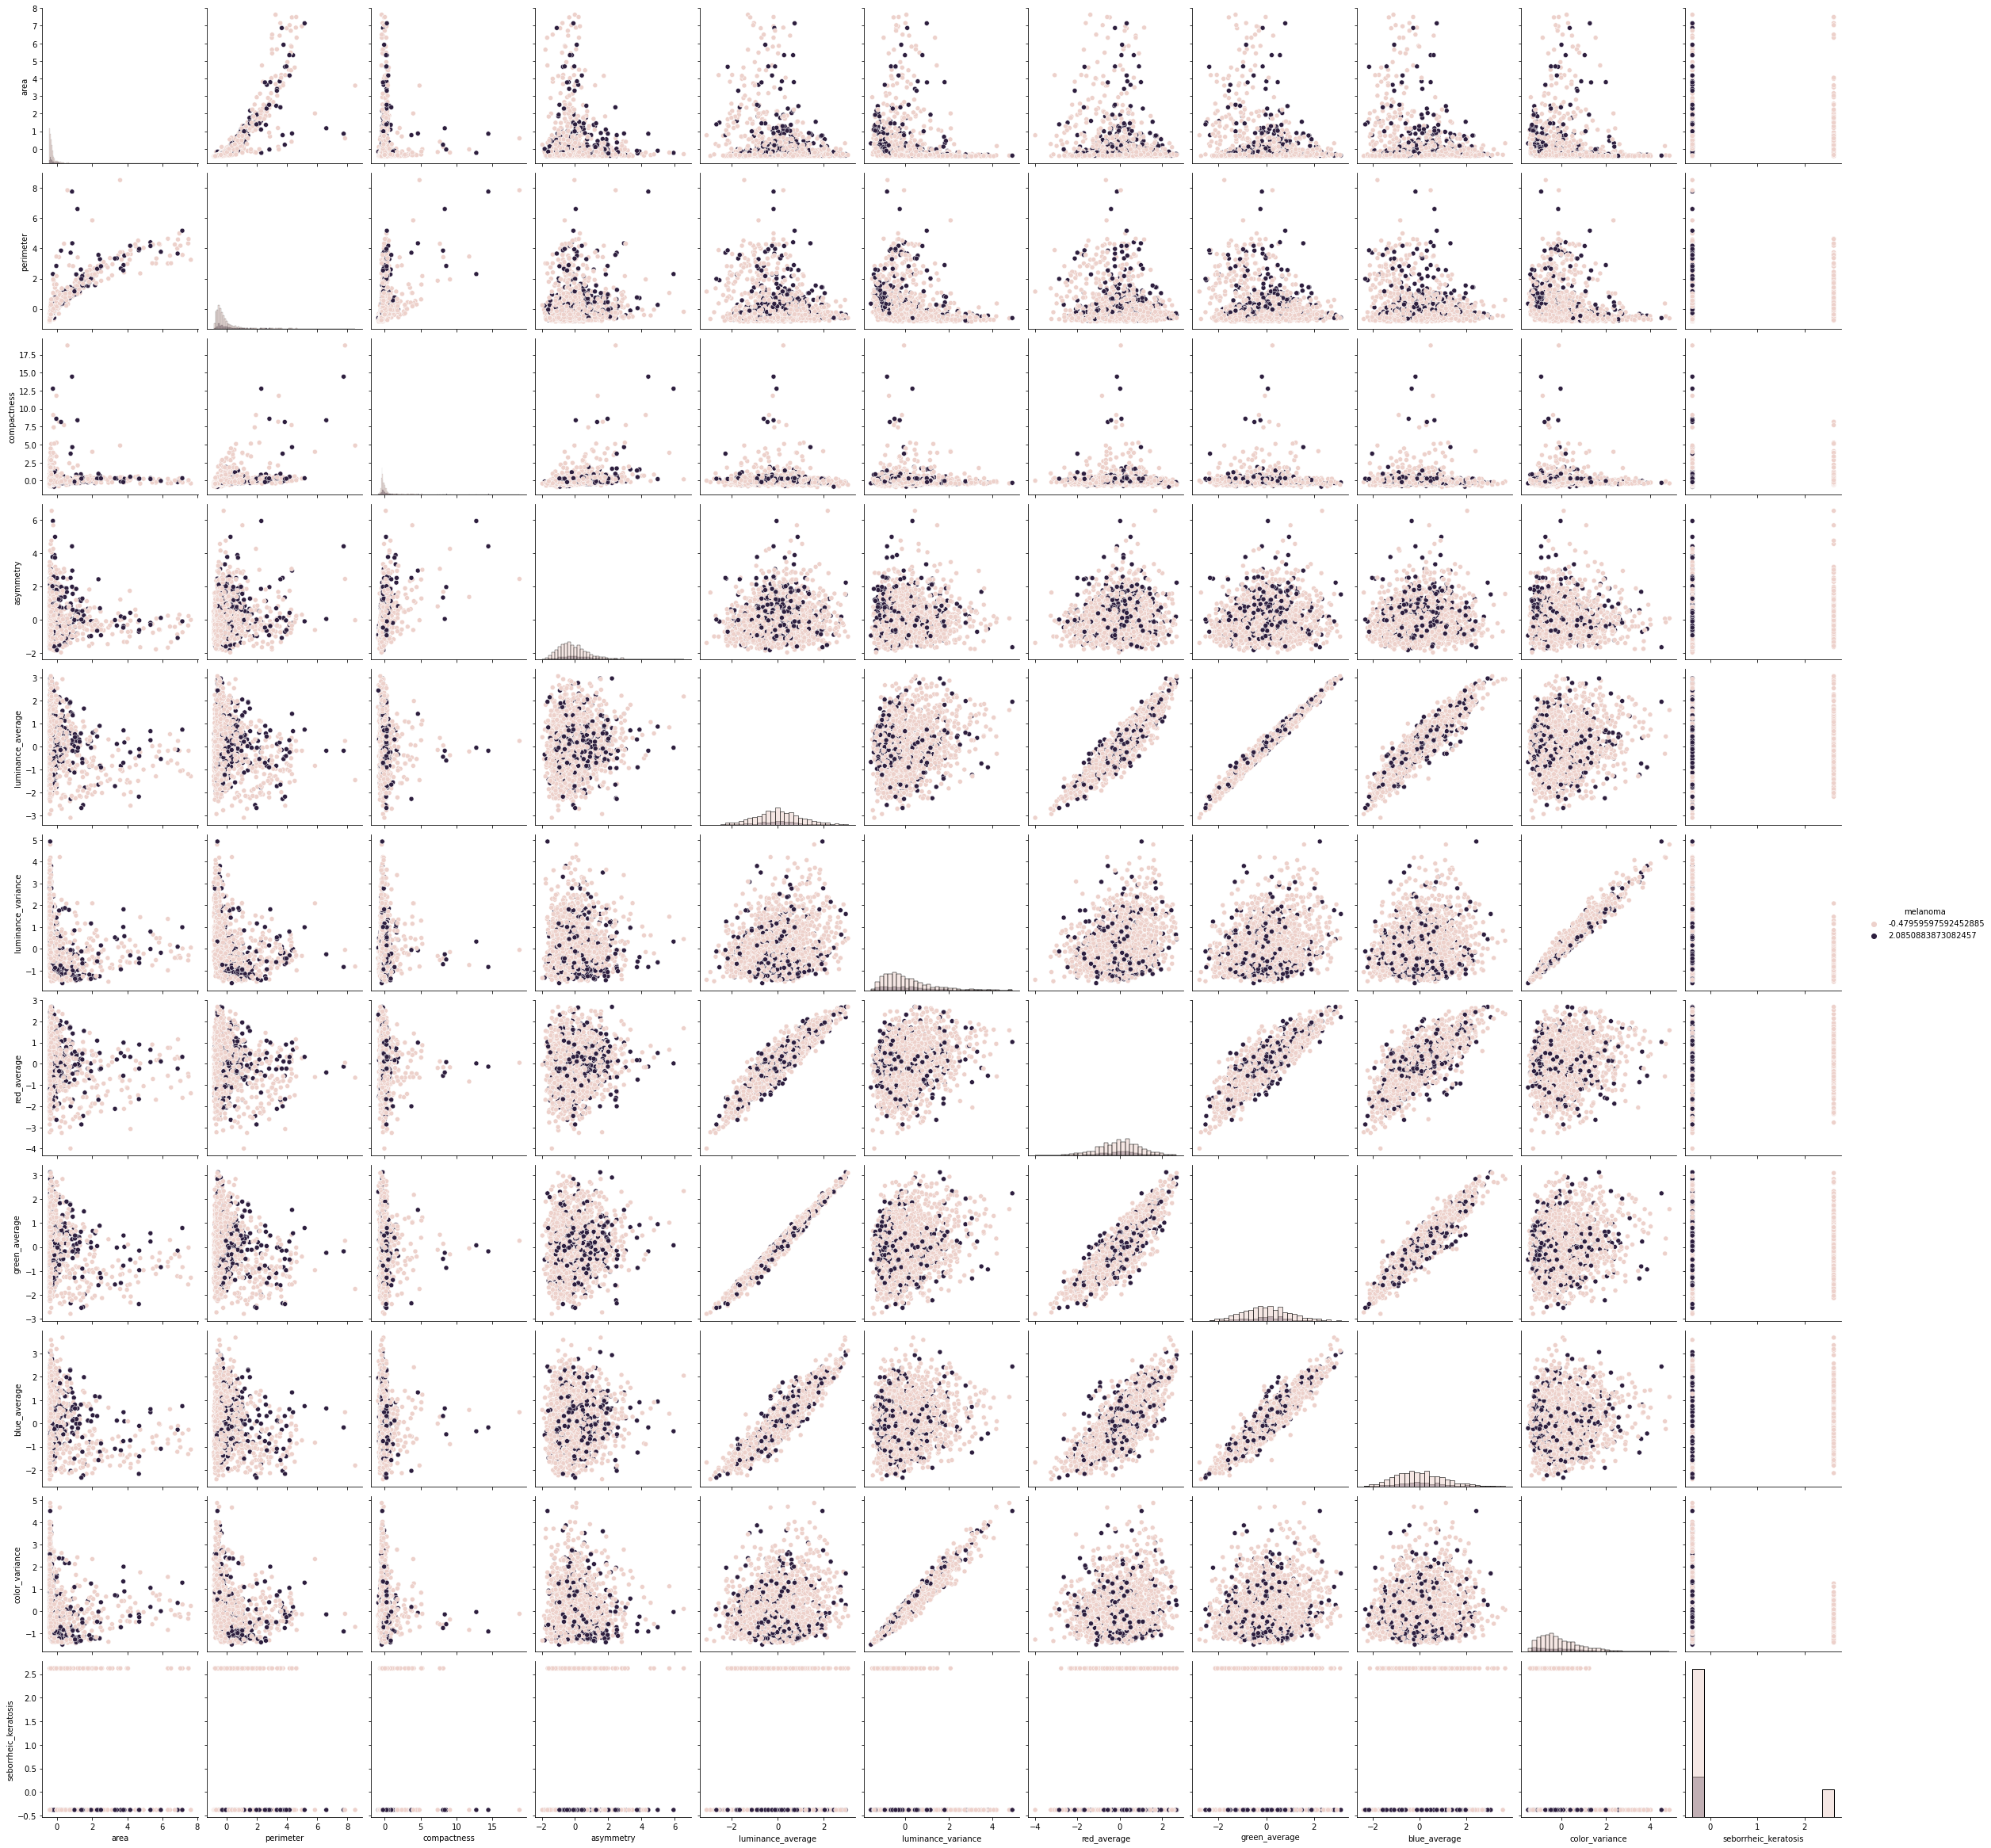

In [140]:
image_data = image_data.drop("image_id", axis=1)
scaler = StandardScaler().fit_transform(image_data.values)
image_data = pd.DataFrame(scaler, index = image_data.index, columns = image_data.columns)



sns.pairplot(image_data, hue = "melanoma", height = 3, diag_kind = "hist")